In [2]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from cobra.io import read_sbml_model
from tqdm import tqdm
from utils.cobra_utils import get_or_create_exchange
from utils.colors import *
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"

# Load and set up model
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
# atpm.bounds = (25, 25)

# Load condition data
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http

In [4]:
# Plot data function for use later
def plot_data(ax,
              t_X_obs,
              X_obs_replicates,
              t_G_obs,
              G_obs_replicates,
              t_A_obs,
              A_obs_replicates,
              lw=2):
    ax.plot(t_X_obs, X_obs_replicates.T, marker="o", lw=0, color=C_BIOMASS, alpha=0.25)
    ax.plot(t_X_obs, X_obs_replicates.mean(axis=0), lw=lw, color=C_BIOMASS)
    
    # Plot whatever substrates present
    ax2 = ax.twinx()
    if not np.sum(G_obs_replicates) == 0:
        ax2.plot(t_G_obs, G_obs_replicates.T, marker="o", lw=lw, color=C_GLUCOSE)
    if not np.sum(A_obs_replicates) == 0:
        ax2.plot(t_A_obs, A_obs_replicates.T, marker="o", lw=lw, color=C_ACETATE)

    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Biomass (g/L)", color=C_BIOMASS)
    ax2.set_ylabel("Substrate (mM)")

    return ax, ax2

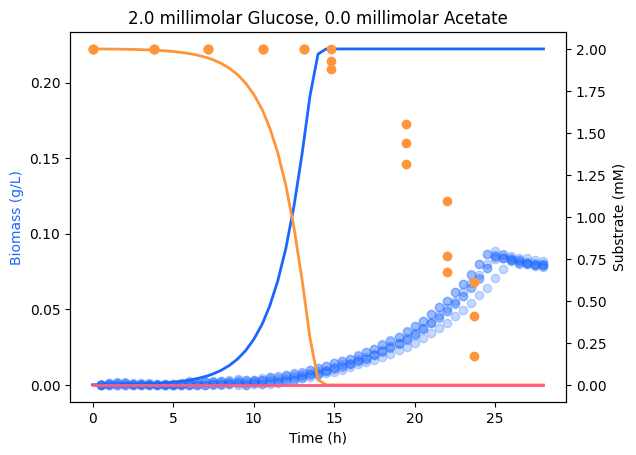

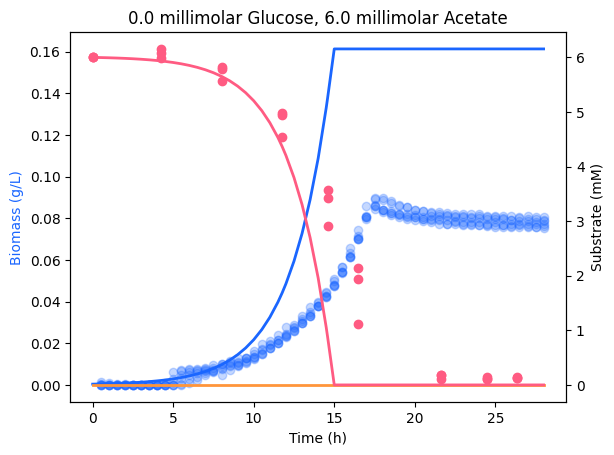

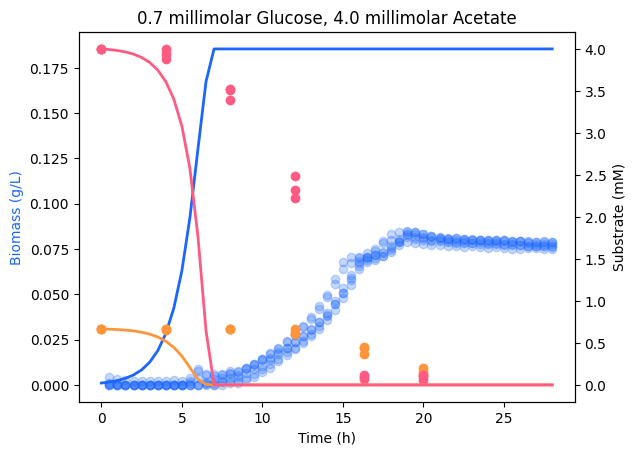

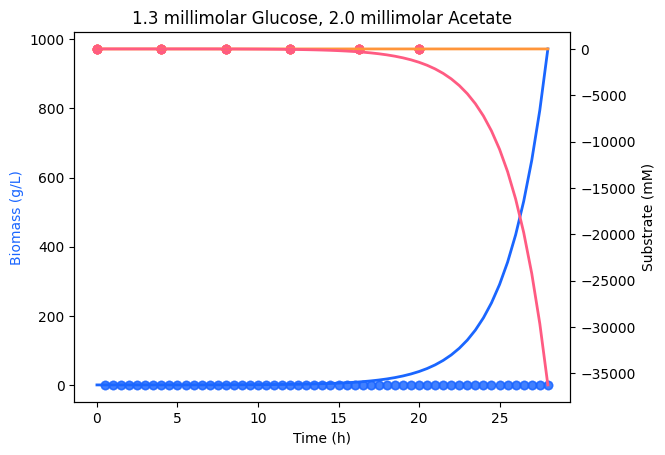

In [5]:
# Parameters
V_max_glc = 5.4357153539065965
K_M_glc = 0.14176287099345153
V_max_ace = 15.012683960622761
K_M_ace = 1.259066961884447e-07

for (g, a), dat in data.items():

    # Get raw data
    t_g = dat["raw"]["raw_g_t"]
    g_s = dat["raw"]["raw_g_s"]
    t_a = dat["raw"]["raw_a_t"]
    a_s = dat["raw"]["raw_a_s"]
    t_X = dat["raw"]["raw_b_t"]
    X_s = dat["raw"]["raw_b"]

    if len(g_s) == 0:
        g_s = np.zeros_like(a_s)
    if len(a_s) == 0:
        a_s = np.zeros_like(g_s)

    # Get initial condition
    X_0 = X_s.mean(axis=0)[0]
    g_0 = g_s.mean(axis=0)[0]
    a_0 = a_s.mean(axis=0)[0]

    def deriv(state, t):
        X, G, A, badness = state
        if badness == 0:
            bound_g = - V_max_glc * (G / (K_M_glc + G))
            bound_a = - V_max_ace * (A / (K_M_ace + A))
            with model:
                ex_glc.bounds = (min(bound_g, 0), 0)
                ex_ace.bounds = (min(bound_a, 0), 0)
                sol = model.optimize()
            
            badness_grad = 0 if sol.status == "optimal" else 1
            return np.array([sol.objective_value,
                            sol.fluxes["EX_glc"],
                            sol.fluxes["EX_ac"],
                            badness_grad]) * X
        else:
            return np.array([0, 0, 0, 0])

    # Run numerical integration
    # (make sure to evaluate at all timepoints in X, G, and A data)
    t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
    sol = odeint(deriv, np.array([X_0, g_0, a_0, 0]), t_eval)

    fig, ax = plt.subplots()
    _, ax2 = plot_data(ax, t_X, X_s, t_g, g_s, t_a, a_s, lw=0)
    ax.plot(t_eval, sol[:, 0], color=C_BIOMASS, lw=2)
    ax2.plot(t_eval, sol[:, 1], color=C_GLUCOSE, lw=2)
    ax2.plot(t_eval, sol[:, 2], color=C_ACETATE, lw=2)
    ax.set_title(f"{g:.1f} Glucose, {a:.1f} Acetate")

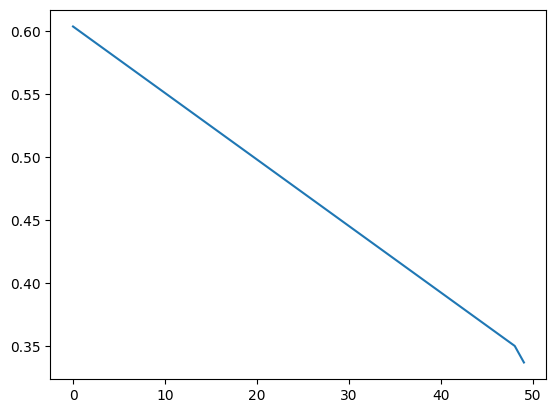

In [11]:
atpm_vals = np.arange(50)
growth_rates = []
with model:
    ex_glc.bounds = (-V_max_glc, 0)

    for atpm_val in atpm_vals:
        atpm.bounds = (atpm_val, atpm_val)
        sol = model.optimize()
        growth_rates.append(sol.objective_value)

fig, ax = plt.subplots()
ax.plot(atpm_vals, growth_rates)
        

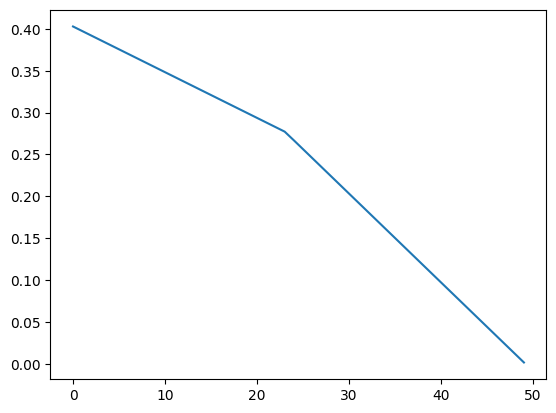

In [12]:
atpm_vals = np.arange(50)
growth_rates = []
with model:
    ex_ace.bounds = (-V_max_ace, 0)

    for atpm_val in atpm_vals:
        atpm.bounds = (atpm_val, atpm_val)
        sol = model.optimize()
        growth_rates.append(sol.objective_value)

fig, ax = plt.subplots()
ax.plot(atpm_vals, growth_rates)

In [6]:
keys = list(data.keys())

data[keys[0]]["raw"]["raw_g_t"], data[keys[1]]["raw"]["raw_a_t"]

(0     0.000000
 1     3.809188
 2     7.195134
 3    10.581079
 4    13.120538
 5    14.813510
 6    19.469185
 7    22.008644
 8    23.701616
 Name: Time (single), dtype: float64,
 0     0.000000
 1     4.234921
 2     7.999295
 3    11.763669
 4    14.586950
 5    16.469137
 6    21.645151
 7    24.468432
 8    26.350619
 Name: Time (single), dtype: float64)

2.0 millimolar Glucose, 0.0 millimolar Acetate: 1it [00:09,  9.97s/it]/home/mica/.pyenv/versions/3.12.1/envs/rpom/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
2.0 millimolar Glucose, 0.0 millimolar Acetate: 20it [03:34, 10.70s/it]
0.0 millimolar Glucose, 6.0 millimolar Acetate: 20it [03:42, 11.12s/it]
0.7 millimolar Glucose, 4.0 millimolar Acetate: 20it [07:23, 22.18s/it]
1.3 millimolar Glucose, 2.0 millimolar Acetate: 20it [06:34, 19.71s/it]


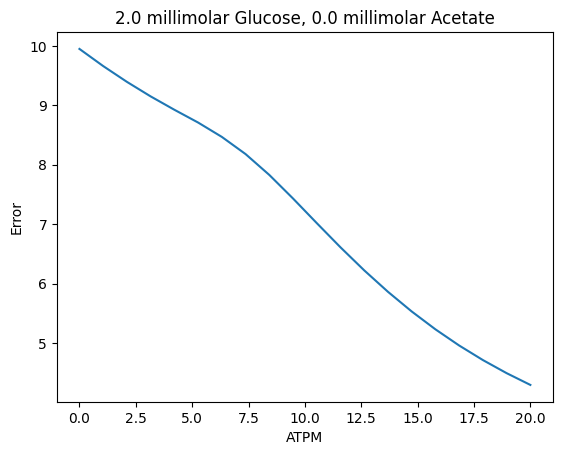

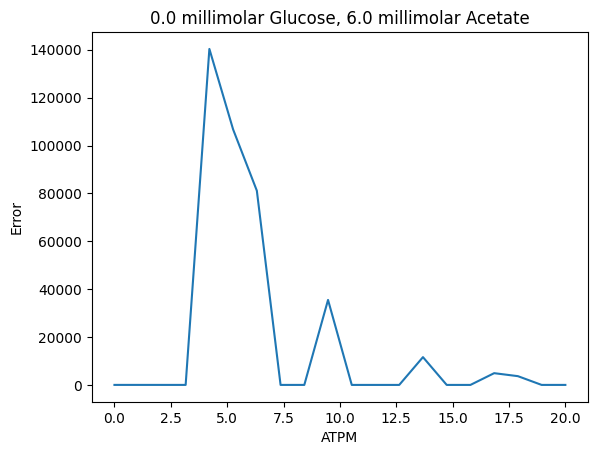

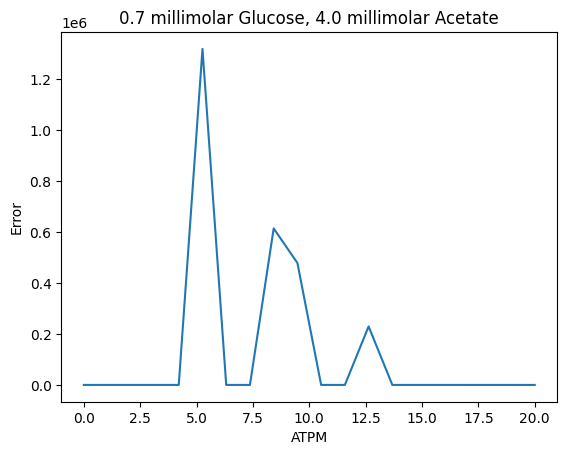

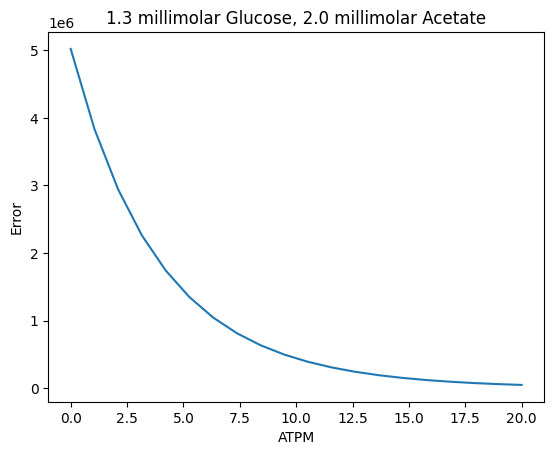

In [7]:
# Error function for data vs. model
def err(t_X, X_obs_replicates,
        t_g, G_obs_replicates,
        t_a, A_obs_replicates,
        t_eval, model_X, model_G, model_A):
    model_X = model_X[np.isin(t_eval, t_X)]
    model_G = model_G[np.isin(t_eval, t_g)]
    model_A = model_A[np.isin(t_eval, t_a)]
    return (
        np.sum((X_obs_replicates.mean(axis=0) - model_X)**2)
        + np.sum((G_obs_replicates.mean(axis=0) - model_G)**2)
        + np.sum((A_obs_replicates.mean(axis=0) - model_A)**2)
    )

for (g, a), dat in data.items():

    # Get raw data
    t_g = dat["raw"]["raw_g_t"]
    g_s = dat["raw"]["raw_g_s"]
    t_a = dat["raw"]["raw_a_t"]
    a_s = dat["raw"]["raw_a_s"]
    t_X = dat["raw"]["raw_b_t"]
    X_s = dat["raw"]["raw_b"]

    if len(g_s) == 0:
        g_s = np.zeros_like(a_s)
    if len(a_s) == 0:
        a_s = np.zeros_like(g_s)

    # Get initial condition
    X_0 = X_s.mean(axis=0)[0]
    g_0 = g_s.mean(axis=0)[0]
    a_0 = a_s.mean(axis=0)[0]

    # Define derivative
    def deriv(state, t):
        X, G, A, badness = state
        if badness == 0:
            bound_g = - V_max_glc * (G / (K_M_glc + G))
            bound_a = - V_max_ace * (A / (K_M_ace + A))
            with model:
                ex_glc.bounds = (min(bound_g, 0), 0)
                ex_ace.bounds = (min(bound_a, 0), 0)
                sol = model.optimize()
            
            badness_grad = 0 if sol.status == "optimal" else 1
            return np.array([sol.objective_value,
                            sol.fluxes["EX_glc"],
                            sol.fluxes["EX_ac"],
                            badness_grad]) * X
        else:
            return np.array([0, 0, 0, 0])
    
    # def work(model, atpm_val):
    #     with model:
    #         # Set maintenance
    #         atpm.bounds = (atpm_val, atpm_val)

    #         # Run numerical integration
    #         # (make sure to evaluate at all timepoints in X, G, and A data)
    #         t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
    #         sol = odeint(deriv, np.array([X_0, g_0, a_0]), t_eval)

    #         model_X, model_G, model_A = sol.T
    #         return err(
    #             t_X, X_s, t_g, g_s, t_a, a_s,
    #             t_eval, model_X, model_G, model_A
    #         )


    atpm_vals = np.linspace(0, 20, 20)
    errors = np.zeros_like(atpm_vals)

    # futures = {}
    # with ThreadPoolExecutor() as ex:
    #     for i, atpm_val in tqdm(enumerate(atpm_vals), "Submitting..."):
    #         future = ex.submit(work, model, atpm_val)
    #         futures[future] = i
    
    # for future in tqdm(as_completed(futures), "Collecting..."):
    #     i = futures[future]
    #     errors[i] = future.result()


    for i, atpm_val in tqdm(enumerate(atpm_vals), desc=f"{g:.1f} Glucose, {a:.1f} Acetate"):
        with model:
            # Set maintenance
            atpm.bounds = (atpm_val, atpm_val)

            # Run numerical integration
            # (make sure to evaluate at all timepoints in X, G, and A data)
            t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
            sol = odeint(deriv, np.array([X_0, g_0, a_0, 0]), t_eval)

            model_X, model_G, model_A, _ = sol.T
            errors[i] = err(
                t_X, X_s, t_g, g_s, t_a, a_s,
                t_eval, model_X, model_G, model_A
            )
    
    fig, ax = plt.subplots()
    ax.plot(atpm_vals, errors)
    ax.set_title(f"{g:.1f} Glucose, {a:.1f} Acetate")
    ax.set_xlabel("ATPM")
    ax.set_ylabel("Error")

In [8]:
# Error function for data vs. model
def err(t_X, X_obs_replicates,
        t_g, G_obs_replicates,
        t_a, A_obs_replicates,
        t_eval, model_X, model_G, model_A):
    model_X = model_X[np.isin(t_eval, t_X)]
    model_G = model_G[np.isin(t_eval, t_g)]
    model_A = model_A[np.isin(t_eval, t_a)]
    return (
        np.sum((X_obs_replicates.mean(axis=0) - model_X)**2)
        + np.sum((G_obs_replicates.mean(axis=0) - model_G)**2)
        + np.sum((A_obs_replicates.mean(axis=0) - model_A)**2)
    )

# Define derivative
def deriv(state, t):
    X, G, A = state
    bound_g = - V_max_glc * (G / (K_M_glc + G))
    bound_a = - V_max_ace * (A / (K_M_ace + A))
    with model:
        ex_glc.bounds = (min(bound_g, 0), 0)
        ex_ace.bounds = (min(bound_a, 0), 0)
        sol = model.optimize()
    return np.array([sol.objective_value,
                    sol.fluxes["EX_glc"],
                    sol.fluxes["EX_ac"]]) * X

atpm_vals = np.linspace(0, 10, 10)

futures = {}
with ThreadPoolExecutor(max_workers=4) as ex:
    for (g, a), dat in tqdm(data.items(), "Submitting..."):
        # Get raw data
        t_g = dat["raw"]["raw_g_t"]
        g_s = dat["raw"]["raw_g_s"]
        t_a = dat["raw"]["raw_a_t"]
        a_s = dat["raw"]["raw_a_s"]
        t_X = dat["raw"]["raw_b_t"]
        X_s = dat["raw"]["raw_b"]

        if len(g_s) == 0:
            g_s = np.zeros_like(a_s)
        if len(a_s) == 0:
            a_s = np.zeros_like(g_s)

        # Get initial condition
        X_0 = X_s.mean(axis=0)[0]
        g_0 = g_s.mean(axis=0)[0]
        a_0 = a_s.mean(axis=0)[0]
        
        def work(model, atpm_val,
                 t_g, g_s,
                 t_a, a_s,
                 t_X, X_s):
            with model:
                # Set maintenance
                atpm.bounds = (atpm_val, atpm_val)

                # Run numerical integration
                # (make sure to evaluate at all timepoints in X, G, and A data)
                t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
                sol = odeint(deriv, np.array([X_0, g_0, a_0]), t_eval)

                model_X, model_G, model_A = sol.T
                return err(
                    t_X, X_s, t_g, g_s, t_a, a_s,
                    t_eval, model_X, model_G, model_A
                )

        errors = np.zeros_like(atpm_vals)
        for i, atpm_val in enumerate(atpm_vals):
            future = ex.submit(work, model.copy(), atpm_val, t_g, g_s, t_a, a_s, t_X, X_s)
            futures[future] = ((g, a), i, atpm_val)

errors = {(g, a) : np.zeros_like(atpm_vals)}
for future in tqdm(as_completed(futures), "Collecting..."):
    ((g, a), i, atpm_val) = futures[future]
    errors[(g, a)][i] = future.result()


        # for i, atpm_val in tqdm(enumerate(atpm_vals), desc=f"{g:.1f} Glucose, {a:.1f} Acetate"):
        #     with model:
        #         # Set maintenance
        #         atpm.bounds = (atpm_val, atpm_val)

        #         # Run numerical integration
        #         # (make sure to evaluate at all timepoints in X, G, and A data)
        #         t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
        #         sol = odeint(deriv, np.array([X_0, g_0, a_0]), t_eval)

        #         model_X, model_G, model_A = sol.T
        #         errors[i] = err(
        #             t_X, X_s, t_g, g_s, t_a, a_s,
        #             t_eval, model_X, model_G, model_A
        #         )

for (g, a), errs in errors.items():
    fig, ax = plt.subplots()
    ax.plot(atpm_vals, errs)
    ax.set_title(f"{g:.1f} Glucose, {a:.1f} Acetate")
    fig.show()

Submitting...:   0%|          | 0/4 [00:00<?, ?it/s]

Submitting...:   0%|          | 0/4 [00:17<?, ?it/s]
/tmp/ipykernel_11542/3753264027.py:62: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(deriv, np.array([X_0, g_0, a_0]), t_eval)


RuntimeError: Set changed size during iteration